# Adversarially trained autoencoder







## Part 2:
In part 2, we add the adversarial part by coupling  the autoencoder with a discriminator.
* A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.
* A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(autoencoder(x))`. Thus this `gan` network maps
latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.

We train the autoencoder using a weighted sum of the mse loss and binary cross entropy on the output of the discriminator.

To do this, the gan will need to have two outputs and two loss functions that are combined via a weighted sum.  There is documentation about that here:  [multi-input-and-multi-output-models](https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models)

In alternation, we train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image classification model.  This uses binary cross entropy loss.



## The autoencoder


Use the same autoencoder structure from part 1.  Do not use a saved version of that autoencoder - just use the same structure, but start with an untrained model.  One of the points of this assignment is to compare the results of training with mse versus training with mse plus adversarial loss.

In [0]:
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Flatten, Dense, Conv2D, Conv2DTranspose, BatchNormalization
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

img_input = keras.Input(shape=(height, width, channels))

# Your network here to connect img_input to img_output
encoder = Sequential()
encoder.add(Conv2D(8, (7,7), activation='sigmoid', input_shape=(32,32,3)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(16, (5,5), activation='sigmoid', input_shape=(26,26,8)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(32, (3,3), activation='sigmoid', input_shape=(22,22,16)))
encoder.add(BatchNormalization())
encoder.add(Flatten())
encoder.add(Dense(32, activation='sigmoid'))
encoder.add(BatchNormalization())
encoder.add(Dense(32, activation='sigmoid'))

decoder = Sequential()
decoder.add(Dense(32, activation='sigmoid'))
decoder.add(BatchNormalization())
decoder.add(Dense(20*20*32, activation='sigmoid'))
decoder.add(BatchNormalization())
decoder.add(Reshape((20,20,32)))
decoder.add(Conv2DTranspose(16, (3,3), activation='sigmoid', input_shape=(20,20,32)))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(8, (5,5), activation='sigmoid', input_shape=(22,22,16)))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(3, (7,7), activation='sigmoid', input_shape=(26,26,8)))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 32)                420080    
_________________________________________________________________
sequential_10 (Sequential)   (None, 32, 32, 3)         483891    
Total params: 903,971
Trainable params: 878,083
Non-trainable params: 25,888
_________________________________________________________________


Here is some code to load the data and display images.

In [0]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]
x_test = x_test[y_test.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
x_test = x_test.reshape(
    (x_test.shape[0],) + (height, width, channels)).astype('float32') / 255.

import matplotlib.pyplot as plt

# input a tensor of shape (num_images, x_size, y_size, channels)
# channels is 1 for greyscale and 3 for color images
def show_images(images):
  # Display tiled images
  n_x = np.int(np.sqrt(images.shape[0]))
  n_y = np.int(np.ceil(images.shape[0]/n_x))
  tile_x = images.shape[1]
  tile_y = images.shape[2]
  figure = np.zeros((tile_x * n_x, tile_y * n_y, images.shape[3]))

  for i in range(n_x):
    for j in range(n_y):
      cur_ind = i+n_x*j
      if (cur_ind >= images.shape[0]):
        break
      cur_image = images[cur_ind, :,:,:]
      figure[i * tile_x: (i + 1) * tile_x,
         j * tile_y: (j + 1) * tile_y] = cur_image

  plt.figure(figsize=(n_x, n_y))
  plt.imshow(np.squeeze(figure))
  ax = plt.gca()
  ax.grid(b=None)

  plt.show()

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two
classes, either "generated image" or "real image that comes from the training set".

In [0]:
discriminator_input = layers.Input(shape=(height, width, channels))

# Your code here for the discriminator
# There is one example of a discriminator in Deep Learning with Python, section 8.5

# Your discriminator should end with the final binary classification layer:

#discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Sequential()
discriminator.add(Conv2D(8, (7,7), activation='sigmoid', input_shape=(32,32,3)))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(16, (5,5), activation='sigmoid', input_shape=(26,26,8)))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(32, (3,3), activation='sigmoid', input_shape=(22,22,16)))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(64, (3,3), activation='sigmoid', input_shape=(20,20,32)))
discriminator.add(BatchNormalization())
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='sigmoid'))
discriminator.add(BatchNormalization())
discriminator.add(Dense(1, activation='sigmoid'))

# discriminator = keras.models.Model(discriminator_input, discriminator_output)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 8)         1184      
_________________________________________________________________
batch_normalization_35 (Batc (None, 26, 26, 8)         32        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 22, 22, 16)        3216      
_________________________________________________________________
batch_normalization_36 (Batc (None, 22, 22, 16)        64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
batch_normalization_37 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 18, 64)        18496     
__________

## The adversarial network

Finally, we setup an adversarial network (AN) that chains the autoencoder and the discriminator. This will move the autoencoder
in a direction that improves its ability to fool the discriminator while still reproducing its input. The AN is meant to be trained with labels that are always "these are real images", so the
weights of `autoencoder` will be updated to make `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is
not what we want!

Note: Setting nontrainable weights may give a warning about a mismatch between trainable and nontrainable weights, but you may ignore that.

You will need to set up your model to have a loss function that is a weighted sum of the mse on the autoencoder and the binary cross entropy from the discriminator.   The link in the introduction gives information about how to do that.



## Training you AN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

'''
for each epoch:
    * Draw a batch of training images
    * Reconstruct images with `autoencoder`
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random images.
    * Train `gan` using these random images, with targets that all say "these are real images". This will update the weights of the autoencoder (only, since discriminator is frozen inside `an`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the autoencoder to fool the discriminator.
'''

The code below does most of this.  You'll need to set up the training on batches.  You should also find a way to get and plot the validation loss - the loss on the test data.  This is not included below.

In [0]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

# Set up the gan to output both the image and the real/fake value from the discriminator
# See https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

inputs = Input(shape=(32,32,3))
x = encoder(inputs)
img = decoder(x)
prob = discriminator(img)
gan = Model(inputs=inputs, outputs=[img,prob])

# loss = { "img": "mse", "prob": "categorical_crossentropy", }
# loss_weights = { "img": 1.0, "prob": 1.0 }
loss = ["mse", "binary_crossentropy"]
loss_weights=[1.0, 0.1]
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss=loss, loss_weights=loss_weights)


In [0]:

batch_size = 128
num_epochs = 100

print('Number of epochs = ' + str(num_epochs))

adv_loss = np.zeros((num_epochs, 3))
val_adv_loss = np.zeros((num_epochs, 3))
disc_loss = np.zeros((num_epochs, 1))

max_ind = x_train.shape[0]
# Start training loop
start = 0
epoch = 0
while epoch < num_epochs:

    if (start == 0):
        cur_perm = np.random.permutation(max_ind)

    # Sample random training images
    stop = start + batch_size
    random_images = x_train[cur_perm[start:stop]]

    # Decode them to reconstructed images
    generated_images = gan.predict(random_images)[0]

    # Combine them with real images
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([0.95*np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])  # 0=real, 1=fake
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the AN model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(real_images, [real_images,misleading_targets])

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

        # Print metrics
        print('discriminator loss at epoch %s: %s' % (epoch, d_loss))
        print('adversarial loss at epoch %s: %s' % (epoch, a_loss))

        adv_loss[epoch,:] = a_loss
        disc_loss[epoch,:] = d_loss

        # Calculate and save the validation loss (mse on image only)
        val_adv_loss[epoch,:] = gan.evaluate(x_test, [x_test, np.ones(x_test.shape[0])])

        epoch += 1

Number of epochs = 100


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at epoch 0: 0.18028562
adversarial loss at epoch 0: [0.18032476, 0.093454756, 0.8687]
1000/1000 [==============================] - 1s 1ms/step
discriminator loss at epoch 1: 0.15551665
adversarial loss at epoch 1: [0.14977415, 0.07991409, 0.69860053]
1000/1000 [==============================] - 0s 172us/step
discriminator loss at epoch 2: 0.34671268
adversarial loss at epoch 2: [0.15738052, 0.07327927, 0.8410126]
1000/1000 [==============================] - 0s 159us/step
discriminator loss at epoch 3: 0.14955622
adversarial loss at epoch 3: [0.18701223, 0.06767388, 1.1933835]
1000/1000 [==============================] - 0s 173us/step
discriminator loss at epoch 4: 0.14134766
adversarial loss at epoch 4: [0.16265929, 0.06852975, 0.9412953]
1000/1000 [==============================] - 0s 156us/step
discriminator loss at epoch 5: 0.13194627
adversarial loss at epoch 5: [0.1432459, 0.065712914, 0.77532995]
1000/1000 [==============================] - 0s 184us/step
discri

Display a few reconstructed images and the training plots:

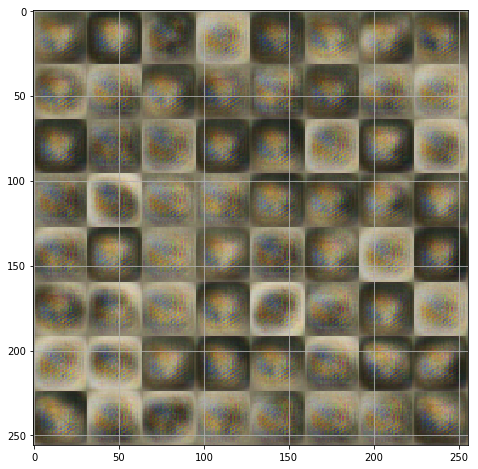

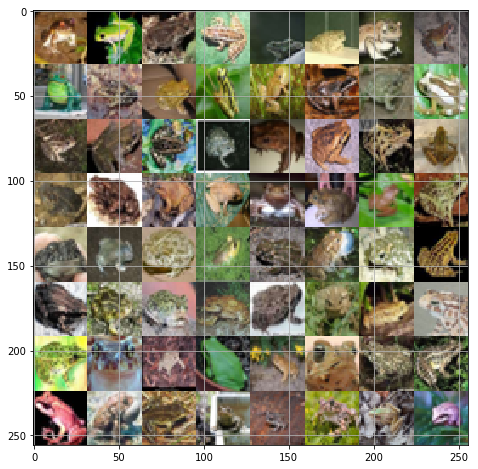

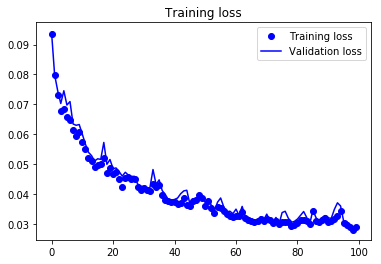

In [0]:
ae_images, discrim = gan.predict(x_train[0:64])
show_images(ae_images)
show_images(x_train[0:64])

loss = adv_loss[:,1]  # Set up so this is mse on the images
val_loss = val_adv_loss[:,1]
epochs = range(num_epochs)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()
